In [3]:
#Generellt användbara bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Transformers bibliotek relaterade till BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

Limit the data to the first 1000 reviews, seeing that I only want to practice a sentiment analysis approach 

In [4]:
data = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
sampeled_data = data[:1000]
sampeled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Initialize the tokenizer and the model. For this sentiment analysis I will be using the roBERTa transformer model to perform the analysis.  

In [5]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Define a function that takes in a reviews-list and a index for retreving a single review. The function should:

    - Retrieve the review that is stored at the index.
    - Tokenize the review with the previously defined tokenizer that is associated with the model. 
    - Feed the tokenized review to the model.
    - Apply the softmax function to the result, which will then return our polarity scores.
    - Assign the polarity scores to integers. 
    - Use the polarity scores integers to calculate a rough score between 1-5 (I arrived at this way of calculating score beeing the best, seeing            that this go the least amount of 'wrong' scores compared to the actual scores left by the user and also being able to caluclate the entire range of 1 - 5).
    - Return a dictionary that contains the:
        1. Negative score
        2. Neutral score
        3. Positive score
        4. Calculated score

In [6]:
def calcPolarityScores(reviews, index):
    sample_review = reviews[index]
    input = tokenizer(sample_review, padding=True, truncation=True, max_length=128, return_tensors="pt")
    result = model(**input)
    polarity_scores = softmax(result[0][0].detach().numpy())
    neg, neu, pos = polarity_scores
    review_score = round(neg*1 + neu*3 + pos*5)
    result_dictionary = {
        "Negative" : neg,
        "Neutral" : neu,
        "Positive" : pos,
        "Calculated score" : review_score,
    }
    return result_dictionary
    

Apply the function to all 1000 reviews in the dataset and store the resulting dictionary for each review in a list called polarity_scores.

In [7]:
polarity_scores = []
for idx, review in sampeled_data.iterrows():
    result = calcPolarityScores(sampeled_data['Text'], idx)
    polarity_scores.append(result)

Convert the contents of the polarity_scores list to a dataframe.

In [16]:
polarity_scores_df = pd.DataFrame(polarity_scores)
polarity_scores_df

,Negative,Neutral,Positive,Calculated score
0,0.009624,0.049980,0.940395,5
1,0.508986,0.452414,0.038600,2
2,0.003229,0.098067,0.898704,5
3,0.002295,0.090219,0.907486,5
4,0.001635,0.010302,0.988063,5
...,...,...,...,...
995,0.001414,0.005883,0.992703,5
996,0.002649,0.016077,0.981274,5
997,0.001362,0.011372,0.987266,5
998,0.661606,0.293687,0.044707,2


Perform a right-join with our polarity_scores dataframe and our original dataframe that contained the first 1000 reviews.

In [17]:
sampeled_data = sampeled_data.join(polarity_scores_df, how = 'right')
sampeled_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Negative,Neutral,Positive,Calculated score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.009624,0.049980,0.940395,5
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.508986,0.452414,0.038600,2
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.003229,0.098067,0.898704,5
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.002295,0.090219,0.907486,5
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.001635,0.010302,0.988063,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,0.001414,0.005883,0.992703,5
996,997,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...",0.002649,0.016077,0.981274,5
997,998,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...,0.001362,0.011372,0.987266,5
998,999,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...,0.661606,0.293687,0.044707,2


Rename the column for the Calculated score to "Calculated_score".

In [20]:
sampeled_data.rename(columns={"Calculated score":"Calculated_score"}, inplace=True)

In [24]:
diff_df = sampeled_data.query("Score != Calculated_score")
diff_df.shape

(342, 14)

By creating a histogram of the dataframe that contains the review where our estimated score did not match the score of the actual review we can see which scores the model typically got wrong. By looking at the histogram below we can see that our model struggeled alot with the higher values

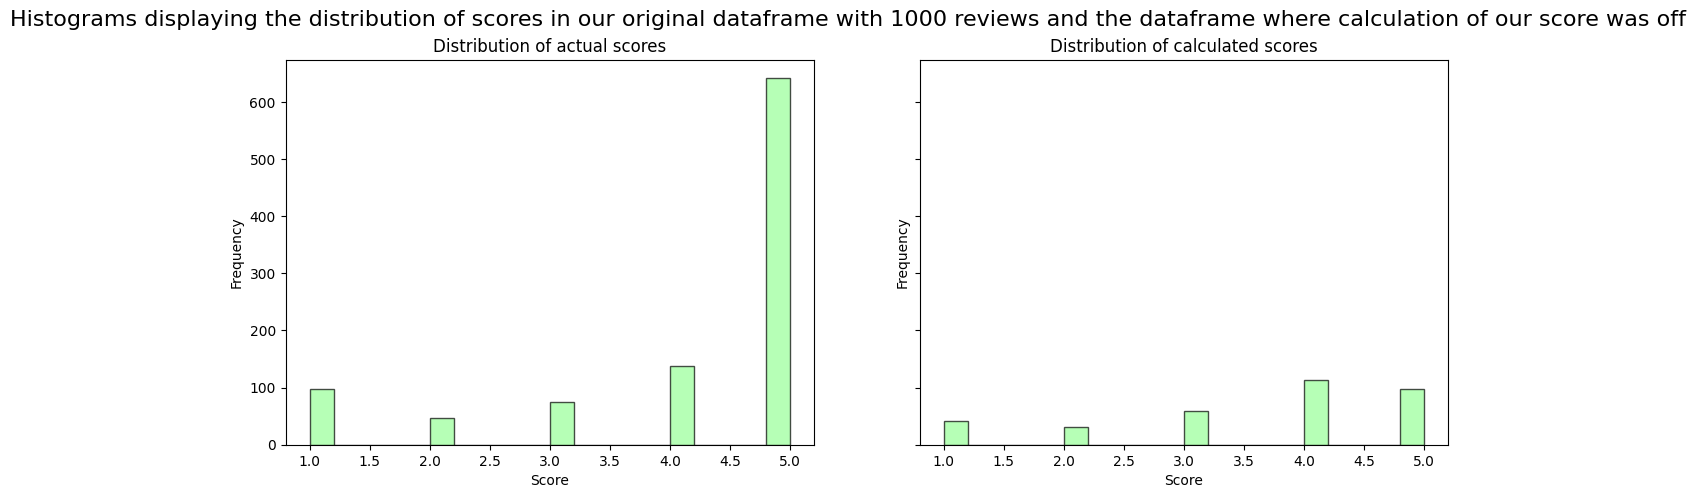

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)  # 1 row, as many columns as needed
fig.suptitle("Histograms displaying the distribution of scores in our original dataframe with 1000 reviews and the dataframe where calculation of our score was off", fontsize = 16)
axes[0].hist(sampeled_data['Score'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[0].set_title("Distribution of actual scores")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")

axes[1].hist(diff_df['Score'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[1].set_title("Distribution of calculated scores")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")

plt.show()

Make histograms depicting the distribution of the different polarity scores and also the distribution of the calculated scores.

Here the model will display it's shortcomings. The way we calculate the score of each review using the result of the model will result from roBERTa is off about ~33% of the time. But the way we calculated the actual score was not very precise and training a pytorch model with the associated score and the expected score would be preferable for actually predicting the scores.

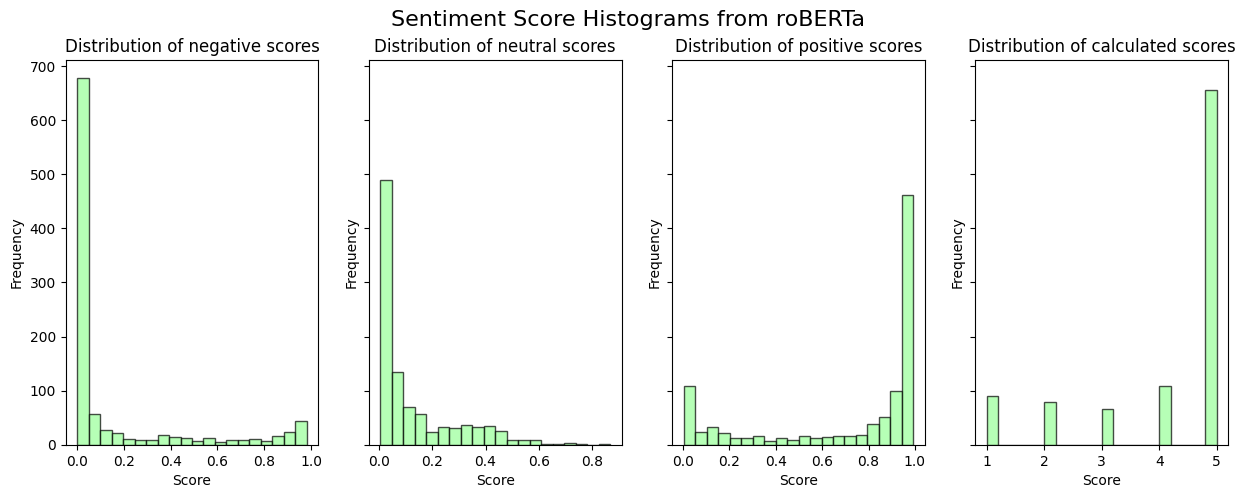

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)  # 1 row, as many columns as needed
fig.suptitle("Sentiment Score Histograms from roBERTa", fontsize = 16)
axes[0].hist(sampeled_data['Negative'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[0].set_title("Distribution of negative scores")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")

axes[1].hist(sampeled_data['Neutral'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[1].set_title("Distribution of neutral scores")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")


axes[2].hist(sampeled_data['Positive'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[2].set_title("Distribution of positive scores")
axes[2].set_xlabel("Score")
axes[2].set_ylabel("Frequency")

axes[3].hist(sampeled_data['Calculated_score'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[3].set_title("Distribution of calculated scores")
axes[3].set_xlabel("Score")
axes[3].set_ylabel("Frequency")

plt.show()